# 使用预训练的卷积神经网络

借助已经在大型数据集上训练良好CNN，帮助解决小型数据集无法充分学习的问题。其中有2种方法：特征提取和微调模型。

## 1. 特征提取

卷积神经网络主要由以下两大部分构成：

__卷积基:__ 由一系列池化层和卷积层构成

__密集连接分类器:__ 针对分类任务设计的由一系列全连接网络构成的分类器

特征提取就是取出之前训练好的网络的卷积基，在上面运行新的数据，然后训练一个新的密集连接分类器。

使用VGG16模型作为卷积基进行研究。

In [1]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet', # 指定模型初始化的权重检查点
                  include_top=False, # 模型最后是否包含密集连接器，VGG16的默认连接器是针对imagenet的1000类输出，此处不需要
                  input_shape=(150, 150, 3)) # 输入形状的张量

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
58892288/58889256 [==============================] - 34s 1us/step


In [2]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

上表显示的是VGG16的卷积基结构，接下来需要在这个结构上添加密集连接分类器，以完成猫和狗的分类任务。

有如下两种方式可以选择：

__1.不使用数据增强的快速特征提取__

在数据集上运行卷积基，将输出保存成numpy数组，然后将这个数组作为输入，训练独立的密集连接分类器中进行训练。

__优点:__ 速度快，计算代价低，在每张图上只运行一次卷积基

__缺点:__ 因为每张图只运行一次卷积基，所以无法进行数据增强

__2.使用数据增强的特征提取__

扩展已有的卷积基模型，在顶部添加密集连接分类器，然后在训练数据上端到端地运行整个模型。

__优点:__　可以使用数据增强

__缺点:__ 卷积基参与大量的运算，运算代价高

### 1.1 不使用数据增强的快速特征提取

In [4]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = '/home/hu/Downloads/dogs-vs-cats_small'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255) # 生成器不使用数据增强，只进行归一化
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        # 将输入通过conv_base进行计算，最终从VGG16输出的是4, 4, 512的张量(参考VGG16的结构)
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # 因为生成器在循环时不断生成数据，所以必须在读完图像后终止循环
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [5]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

在得到VGG16的输出后，单独训练一个密集连接分类器：

In [6]:
from keras import models
from keras import layers
from keras import optimizers

# 密集连接分类器
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 407us/step - loss: 0.6334 - acc: 0.6480 - val_loss: 0.4360 - val_acc: 0.8330
Epoch 2/30
2000/2000 [==============================] - 0s 207us/step - loss: 0.4269 - acc: 0.8035 - val_loss: 0.3589 - val_acc: 0.8540
Epoch 3/30
2000/2000 [==============================] - 0s 214us/step - loss: 0.3618 - acc: 0.8440 - val_loss: 0.3181 - val_acc: 0.8730
Epoch 4/30
2000/2000 [==============================] - 0s 204us/step - loss: 0.3107 - acc: 0.8725 - val_loss: 0.2990 - val_acc: 0.8940
Epoch 5/30
2000/2000 [==============================] - 0s 220us/step - loss: 0.2828 - acc: 0.8840 - val_loss: 0.2826 - val_acc: 0.8780
Epoch 6/30
2000/2000 [==============================] - 0s 212us/step - loss: 0.2574 - acc: 0.8990 - val_loss

绘制图像：

可以发现验证集准确率提升到90%。虽然使用0.5的dropout，但是仍然存在过拟合现象。

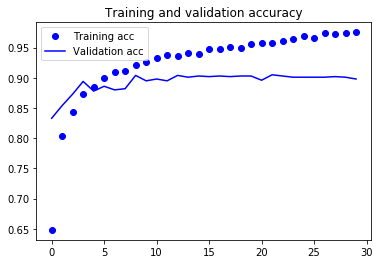

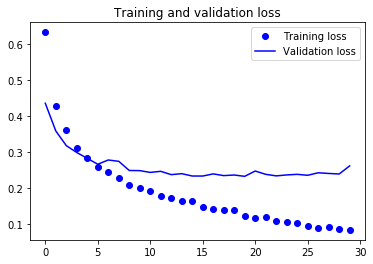

In [8]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### 1.2 使用数据增强的特征提取

将conv_base和密集连接分类器一起构成新的CNN结构：

In [9]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


VGG16的参数非常多，因此需要冻结卷积基。在未冻结之前，有30个weights需要被训练:

In [11]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


冻结的方式是将trainable参数设置为false，冻结后只有4个weights需要被训练:

In [12]:
conv_base.trainable = False

In [13]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


此时可以使用__数据增强__来扩充训练数据，然后对网络进行端到端的训练：

In [14]:
from keras.preprocessing.image import ImageDataGenerator

# 对训练集进行数据增强
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# 注意：对测试集不能进行数据增强！！！
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        # 因为使用binary_crossentropy作为损失函数，所以要使用binary的标签
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
 - 18s - loss: 0.5917 - acc: 0.7050 - val_loss: 0.4560 - val_acc: 0.8070
Epoch 2/30
 - 17s - loss: 0.4901 - acc: 0.7785 - val_loss: 0.3862 - val_acc: 0.8460
Epoch 3/30
 - 17s - loss: 0.4434 - acc: 0.8020 - val_loss: 0.3530 - val_acc: 0.8390
Epoch 4/30
 - 17s - loss: 0.4103 - acc: 0.8195 - val_loss: 0.3100 - val_acc: 0.8690
Epoch 5/30
 - 16s - loss: 0.3868 - acc: 0.8345 - val_loss: 0.2986 - val_acc: 0.8740
Epoch 6/30
 - 16s - loss: 0.3816 - acc: 0.8325 - val_loss: 0.2891 - val_acc: 0.8780
Epoch 7/30
 - 16s - loss: 0.3659 - acc: 0.8360 - val_loss: 0.2809 - val_acc: 0.8860
Epoch 8/30
 - 16s - loss: 0.3506 - acc: 0.8495 - val_loss: 0.2755 - val_acc: 0.8870
Epoch 9/30
 - 16s - loss: 0.3414 - acc: 0.8560 - val_loss: 0.2677 - val_acc: 0.8870
Epoch 10/30
 - 16s - loss: 0.3379 - acc: 0.8475 - val_loss: 0.2693 - val_acc: 0.8820
Epoch 11/30
 - 16s - loss: 0.3386 - acc: 0.8540 - val_loss: 0.2625 - val_ac

In [15]:
model.save('cats_and_dogs_small_3.h5')

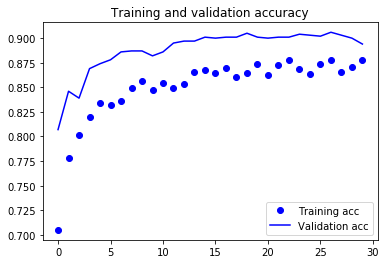

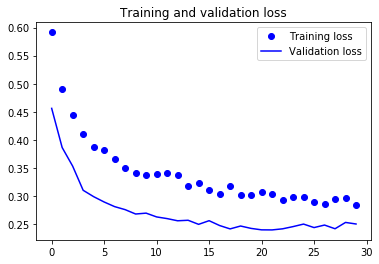

In [16]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

从上图可以看出，验证集上的效果比之前的几种方法都要好。说明使用数据增强和预训练网络可以有效的提升小样本问题的准确率。

## 2. 微调模型

微调是指将其顶部的几层解冻，并将解冻的层和新增加的部分进行联合训练。具体步骤：

1. 在已经训练好的卷积基上添加自定义网络

2. 冻结基网络

3. 训练所添加的部分

4. 解冻基网络的部分层

5. 联合训练解冻层和添加的自定义网络

In [17]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

参考上面的VGG16卷积基，将从block5_conv1层进行解冻，之前的层继续冻结，之后的层将参与训练。

__微调顶部卷积层的原因：__

1. 卷积基中更靠近底部的卷积层编码的是更加通用的可复用特征，而更靠近顶部的层编码的是更专业化的特征。微调顶部将帮助模型更适应特定的问题。

2. 微调的层越多，训练的参数将越多，最终过拟合的风险越大。所以最好的选择是微调卷积基靠近顶部的网络层。

In [18]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [19]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5), # 适当降低学习率，以保证微调的效果
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/100
100/100 [==============================] - 18s 180ms/step - loss: 0.2874 - acc: 0.8765 - val_loss: 0.2530 - val_acc: 0.9070
Epoch 2/100
100/100 [==============================] - 17s 173ms/step - loss: 0.2493 - acc: 0.8940 - val_loss: 0.2292 - val_acc: 0.9110
Epoch 3/100
100/100 [==============================] - 17s 173ms/step - loss: 0.2412 - acc: 0.8950 - val_loss: 0.2064 - val_acc: 0.9200
Epoch 4/100
100/100 [==============================] - 17s 167ms/step - loss: 0.2133 - acc: 0.9110 - val_loss: 0.2536 - val_acc: 0.9070
Epoch 5/100
100/100 [==============================] - 16s 162ms/step - loss: 0.1999 - acc: 0.9130 - val_loss: 0.2266 - val_acc: 0.9170
Epoch 6/100
100/100 [==============================] - 17s 167ms/step - loss: 0.1993 - acc: 0.9195 - val_loss: 0.2007 - val_acc: 0.9170
Epoch 7/100
100/100 [==============================] - 18s 178ms/step - loss: 0.1957 - acc: 0.9170 - val_loss: 0.1747 - val_acc: 0.9270
Epoch 8/100
100/100 [===========================

Epoch 61/100
100/100 [==============================] - 16s 162ms/step - loss: 0.0379 - acc: 0.9855 - val_loss: 0.3144 - val_acc: 0.9310
Epoch 62/100
100/100 [==============================] - 16s 165ms/step - loss: 0.0293 - acc: 0.9910 - val_loss: 0.3165 - val_acc: 0.9270
Epoch 63/100
100/100 [==============================] - 17s 171ms/step - loss: 0.0287 - acc: 0.9900 - val_loss: 0.2181 - val_acc: 0.9370
Epoch 64/100
100/100 [==============================] - 17s 167ms/step - loss: 0.0285 - acc: 0.9885 - val_loss: 0.2751 - val_acc: 0.9360
Epoch 65/100
100/100 [==============================] - 16s 161ms/step - loss: 0.0331 - acc: 0.9870 - val_loss: 0.2478 - val_acc: 0.9380
Epoch 66/100
100/100 [==============================] - 16s 163ms/step - loss: 0.0329 - acc: 0.9895 - val_loss: 0.3007 - val_acc: 0.9270
Epoch 67/100
100/100 [==============================] - 16s 164ms/step - loss: 0.0186 - acc: 0.9950 - val_loss: 0.2662 - val_acc: 0.9400
Epoch 68/100
100/100 [===================

In [20]:
model.save('cats_and_dogs_small_4.h5')

绘制图像：

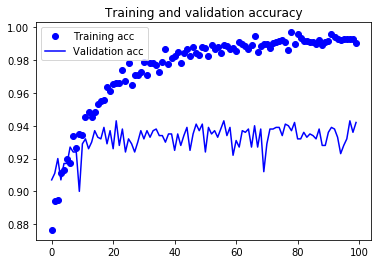

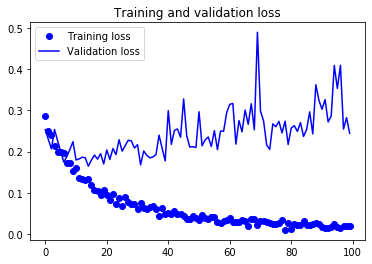

In [21]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

平滑图像：

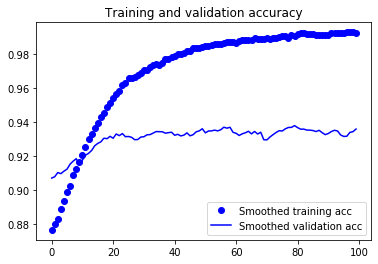

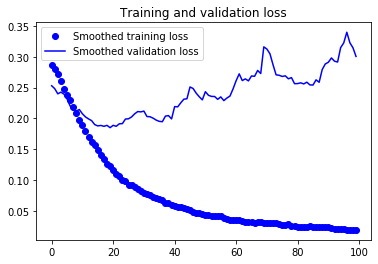

In [23]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

从上图可以看到模型在验证集上的准确率进一步提升。说明进一步的微调是有效的。

最后在测试数据上验证模型准确率：

In [24]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
test acc: 0.9389999902248383
